In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import interpn
import matplotlib.colors as colors
from loadmodules import *

%matplotlib inline

In [27]:
sim = 'iso_gal_aur'
s = gadget_readsnap(30, snappath=sim+'/output/', applytransformationfacs=True, hdf5=True)

unit_time = s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s
unit_mass = s.UnitMass_in_g
unit_length = s.UnitLength_in_cm
unit_velocity = s.UnitVelocity_in_cm_per_s

gyr = 3.15569e16
solarmass = 1.989e33
kpc = 3.086e21

/home/pdcg/pylib/gadget_snap.py:730: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


In [28]:
mask_clusters_initial = s.data['incl'] > 0
mask_clusters_final = s.data['nclt'] > 0

truncation_mass = s.data['mtrc'][mask_clusters_initial]
cluster_masses = s.data['mclt'][mask_clusters_initial].flatten()
cluster_radius = s.data['rclt'][mask_clusters_initial].flatten()
init_cluster_masses = s.data['imcl'][mask_clusters_initial].flatten()
init_cluster_radius = s.data['ircl'][mask_clusters_initial].flatten()
masslostrelax = s.data['mlrx'][mask_clusters_initial].flatten()
masslostshock = s.data['mlsk'][mask_clusters_initial].flatten()

not_empty_clusters = (init_cluster_masses>0)

cluster_masses = cluster_masses[not_empty_clusters]
cluster_radius = cluster_radius[not_empty_clusters]
init_cluster_masses = init_cluster_masses[not_empty_clusters]
init_cluster_radius = init_cluster_radius[not_empty_clusters]
masslostrelax = masslostrelax[not_empty_clusters]
masslostshock = masslostshock[not_empty_clusters]

In [29]:
clusters_birthtime = np.repeat(s.data['age'], s.data['incl'])

In [30]:
clusters_disruptiontime = s.data['drpt'][mask_clusters_initial].flatten()
clusters_disruptiontime = clusters_disruptiontime[not_empty_clusters]

In [31]:
lifetime_gyr = (clusters_disruptiontime - clusters_birthtime) * unit_time / gyr
lifetime_gyr[(lifetime_gyr<0)] = 3.5

In [32]:
msh_mrlx = masslostshock/masslostrelax

min_icmf = 5e3 # in solar masses
max_icmf = 1e8 # in solar masses
marray_icmf = np.logspace(np.log10(min_icmf), np.log10(max_icmf), 25)

min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), 25)

min_rh = 1e-2 # in parsecs
max_rh = 2e2 # in parsecs
rharray = np.logspace(np.log10(min_rh), np.log10(max_rh), 25) # in pc

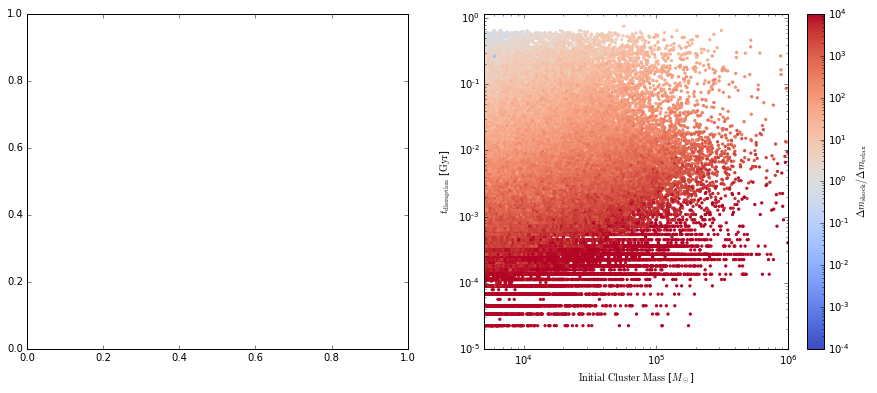

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15, 6))

# TRY WITH projections MODULE

cb = ax[1].scatter(init_cluster_masses*1e10, lifetime_gyr, c = msh_mrlx, edgecolors='face', s=5, cmap=cm.coolwarm, norm=cm.colors.LogNorm(vmin=1e-4, vmax=1e4))
ax[1].set(xscale='log', xlim=(5e3, 1e6), yscale='log', ylim=(1e-5, lifetime_gyr.max()))
ax[1].set(xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$t_{\rm{disruption}}$ [$\rm{Gyr}$]')
cbar = fig.colorbar(cb, ax=ax[1], label=r'$\Delta m_{\rm{shock}}/\Delta m_{\rm{relax}}$')
# ax[1].tick_params(labelsize=12)
# plt.tight_layout()
# plt.savefig('iso_smug_disruption.png')

In [21]:
mevminit = masslostrelax/init_cluster_masses
mshminit = masslostshock/init_cluster_masses

In [22]:
def density_scatter( x , y, vmin, vmax, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density=False)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    h = ax.scatter( x, y, c=z, norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap=cm.viridis, **kwargs )

    return ax, h

Text(0, 0.5, 'Inital Cluster Radius [pc]')

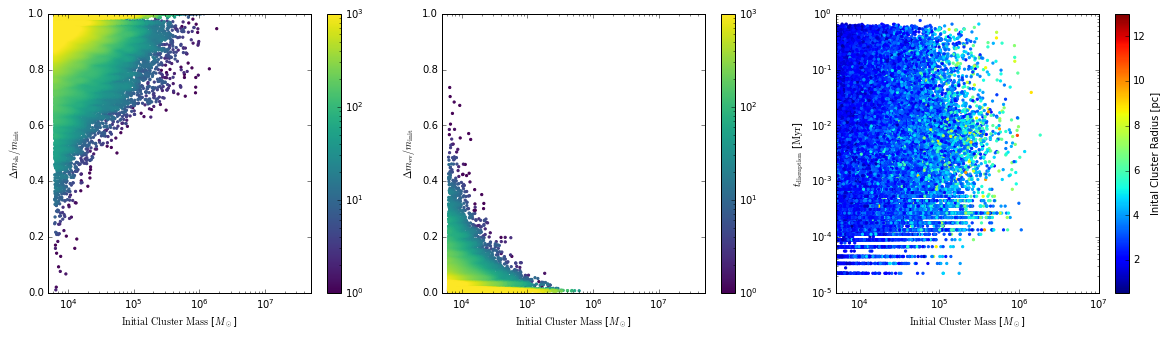

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0], cb1 = density_scatter(init_cluster_masses*1e10, mshminit, vmin=1e0, vmax=1e3, ax=ax[0],bins=[marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[0].set(xscale='log', xlim=(5e3, 5e7), ylim=(0,1), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\Delta m_{\rm{sh}}/m_{\rm{init}}$')
cbar = fig.colorbar(cb1, ax=ax[0])

ax[1], cb1 = density_scatter(init_cluster_masses*1e10, mevminit, vmin=1e0, vmax=1e3, ax=ax[1],bins=[marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[1].set(xscale='log', xlim=(5e3, 5e7), ylim=(0,1), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\Delta m_{\rm{ev}}/m_{\rm{init}}$')
cbar = fig.colorbar(cb1, ax=ax[1])

cb2 = ax[2].scatter(init_cluster_masses*1e10, lifetime_gyr, c=init_cluster_radius*1e3, edgecolors='face', s=5)
ax[2].set(xscale='log', yscale='log', xlim=(5e3, 1e7), ylim=(1e-5, 1e0))
ax[2].set(xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$t_{\rm{disruption}}$ [$\rm{Myr}$]')
cbar = fig.colorbar(cb2, ax=ax[2])
cbar.ax.set_ylabel('Inital Cluster Radius [pc]')